# Solve the moments

## Prepare

In [1]:
import numpy as np
from numpy import linalg as la
from scipy import integrate
from scipy import optimize
from scipy import interpolate
import scipy as sp
from matplotlib import pyplot as plt
import sys

Abs = np.abs
Log = np.log
Log10 = np.log10
Pi = np.pi
Sqrt = np.sqrt
Exp = np.exp
Cos = np.cos
Sin = np.sin
Sech = lambda x: 1/np.cosh(x)
ArcSin = np.arcsin
ArcTanh = np.arctanh
Arg = np.angle
BesselK = sp.special.kv
Zeta = sp.special.zeta
HeavisideTheta = lambda x: np.heaviside(x, 0)


def Plot(fun, xminmax, n=100,xfun=np.linspace, xlog=False, ylog=False):
    xlist = xfun(xminmax[0], xminmax[1], n)
    ylist = [fun(x) for x in xlist]
    plt.plot(xlist, ylist)
    if xlog:
        plt.xscale('log')
    if ylog:
        plt.yscale('log')

from helperFunctions import derivative, alpha_p, cs_sq, dYdtau, dvTdxi, r_func, μ, w

plt.rc('text', usetex=True)
plt.rc('font', family='serif', size='20')
plt.rc('text.latex', preamble=r'\usepackage{wasysym}')

In [2]:
#current_dir = os.path.dirname(os.path.abspath(__file__))
#model_directory = os.path.join(current_dir, '..', 'cosmotransition_z2sb', 'cosmoTransitions')
model_directory='/Users/quarkquartet/Work/Wall-velocity/model/'
sys.path.append(model_directory)
import baseMo_s_b_d as bm

### Load a benchmark

In [3]:
m = bm.model(702.654702269, -102.146250858, 0.112009439661, 0.0037322807528, -0.0370639674565,10000)
m.findAllTransitions()
hv = m.TnTrans[0]['high_vev']
lv = m.TnTrans[0]['low_vev']
Tnuc = m.TnTrans[0]['Tnuc']
Vtot = m.Vtot

Tracing phase starting at x = [246.00000051 572.58176356] ; t = 0.0
Tracing minimum up
traceMinimum t0 = 0
.

..........................................................................................................................................................................
Tracing phase starting at x = [-2.27347289e-07  1.79312356e+02] ; t = 68.27354525855334
Tracing minimum down
traceMinimum t0 = 68.2735
..............................................................................
Tracing minimum up
traceMinimum t0 = 68.2735
..........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [4]:
def match(vp,vm,Tp,Tm, high_vev, low_vev):
    r = r_func(Vtot, Tp, Tm, high_vev, low_vev)
    αp = alpha_p(Vtot, Tp, Tm, high_vev, low_vev)
    vpvm = 1-(1-3*αp)*r
    vpvm = vpvm/(3-3*(1+αp)*r)
    ratio = 3 + (1-3*αp)*r
    ratio = ratio/(1+3*(1+αp)*r)
    return [vp*vm - vpvm, vp/vm - ratio]

def find_Tsh(Tm, vw):
    guess_sol = optimize.fsolve(lambda x:match(x[0], vw, x[1], Tm,hv, lv),[0.1,Tnuc])
    try:
        vsol=integrate.solve_ivp(dYdtau, (10,0.01), np.array([μ(vw, guess_sol[0]), guess_sol[1], vw]),t_eval=np.linspace(10,0.01,1000),method='DOP853',args=(Vtot, hv))
        xi_max = vsol.y[2].max()
        xi_max_index = vsol.y[2].argmax()
        v_prof = interpolate.interp1d(vsol.y[2][0:xi_max_index+1],vsol.y[0][0:xi_max_index+1])
        T_prof = interpolate.interp1d(vsol.y[2][0:xi_max_index+1],vsol.y[1][0:xi_max_index+1])
        xsh=optimize.brentq(lambda x: μ(x, v_prof(x))*x - cs_sq(Vtot, T_prof(x), hv), vw, xi_max*0.9999)
    except:
        vTsol = integrate.solve_ivp(dvTdxi, (vw, 1), np.array([μ(vw, guess_sol[0]), guess_sol[1]]), t_eval=np.linspace(vw, 1, 500), method='DOP853', args=(Vtot, hv))
        v_prof = interpolate.interp1d(vTsol.t, vTsol.y[0], kind='cubic')
        T_prof = interpolate.interp1d(vTsol.t, vTsol.y[1], kind='cubic')
        xsh = optimize.brentq(lambda x: μ(x, v_prof(x))*x - cs_sq(Vtot, T_prof(x), hv), vw, 1)
    return T_prof(xsh)

In [21]:
Tmax = m.TnTrans[0]['Tnuc']
Tmin = 55
vw = 0.5
for i in range(30):
    Tcal=(Tmax+Tmin)/2
    Tsh = find_Tsh(Tcal, vw)
    if Tsh < m.TnTrans[0]['Tnuc']:
        Tmin = Tcal
    else:
        Tmax = Tcal
Tm = Tcal
vp, Tp = optimize.fsolve(lambda x:match(x[0],vw,x[1], Tcal, hv, lv),[0.3, Tnuc], xtol=1e-10)

In [22]:
Tm

59.96295744338835

## Load field value profile

In [11]:
h0 = lv[0]
s0 = lv[1]-hv[1]
s_initial=hv[1]
def h_profile(z,Lh):
    z = np.asanyarray(z)
    hz = 0.5*h0*(1-np.tanh(z/Lh))
    return hz

def s_profile(z, Ls, deltas):
    z = np.asanyarray(z)
    sz = 0.5*s0*(1-np.tanh(z/Ls + deltas)) + s_initial
    return sz

c1 = w(Vtot, Tp, hv) * vp/(1-vp**2)
s1=c1
c2=-Vtot(hv, Tp)+ w(Vtot, Tp, hv) * vp**2 /(1-vp**2)
s2=c2

def T33(T,z, Lh, Ls, deltas):
    derh = derivative(lambda zvalue: h_profile(zvalue,Lh),z)
    ders = derivative(lambda zvalue: s_profile(zvalue,Ls,deltas),z)
    field_value = [h_profile(z, Lh), s_profile(z, Ls, deltas)]
    return (0.5*(derh**2 + ders**2) - Vtot(field_value, T) - 0.5*w(Vtot, T, field_value) + 0.5*(4*s1**2 + w(Vtot, T, field_value)**2)**0.5 - s2)/1e6

## Calculate moments

In [12]:
def moments(Lh, Ls, deltas):
    npoints = 100
    z_range = np.linspace(-5*max(Lh,Ls), 5*max(Lh,Ls), npoints)
    T_sol = np.zeros((npoints,))
    for i in range(npoints):
        T33min = optimize.minimize(lambda T: T33(T[0], z_range[i], Lh, Ls, deltas), 55, method='Nelder-Mead', bounds=[(40,90)])
        if T33min.fun > 0:
            T_sol[i]=T33min.x[0]
        else:
            try:
                s = optimize.newton(lambda T: T33(T, z_range[i], Lh, Ls, deltas), Tnuc)
            except:
                s = optimize.fsolve(lambda T: T33(T[0], z_range[i], Lh, Ls, deltas), Tnuc)[0]
            T_sol[i] = s

    hvalues = h_profile(z_range, Lh)
    svalues = s_profile(z_range, Ls, deltas)
    fields = np.array([hvalues, svalues]).T
    dV = m.gradV(fields, T_sol)
    Eh = dV[:,0]
    Es = dV[:,1]
    hprime = np.vectorize(lambda z: -0.5*(h0*Sech(z/Lh)**2)/Lh)
    sprime = np.vectorize(lambda z: -0.5*(s0*Sech(deltas + z/Ls)**2)/Ls)
    Ph = np.trapz(- Eh * hprime(z_range), z_range)
    Gh = np.trapz(- Eh * hprime(z_range) * np.tanh(z_range/Lh), z_range)
    Ps = np.trapz(- Es * sprime(z_range), z_range)
    Gs = np.trapz(- Es * sprime(z_range) * np.tanh(z_range/Ls + deltas), z_range)
    return np.array([Ph, Ps, Gh, Gs])/1e6

In [13]:
moments(0.01,0.01,0.3)

array([-10.18086717,  -1.01247645,   1.16582995,   1.02158784])

In [14]:
def force_diff(Lh, Ls, deltas):
    Ph, Ps, Gh, Gs = moments(Lh, Ls, deltas)
    return Ph-Ps

$\delta s$ should be determined by $P_h - P_s$. By physical meaning, this should be a monotomic function of $\delta s$.

### Solve $\delta s$, then $L_s$, then $L_h$.

In [15]:
def solve_deltas(Lh, Ls):
    try:
        dsol = optimize.newton(lambda d: force_diff(Lh, Ls, d), 0.1)
    except:
        try:
            dsol = optimize.newton(lambda d: force_diff(Lh, Ls, d), -0.1)
        except:
            dsol = optimize.brentq(lambda d: force_diff(Lh, Ls, d), -5,5)
    return dsol

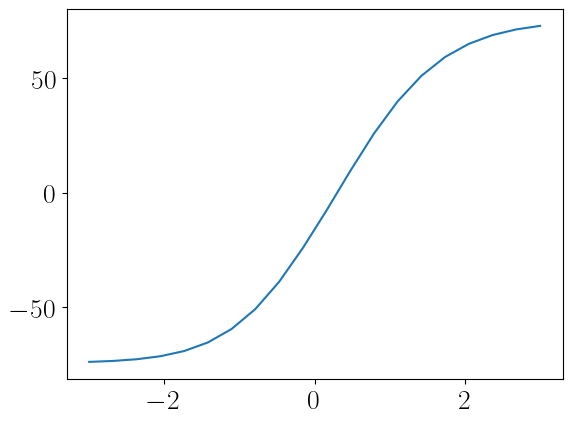

In [16]:
Plot(lambda d: force_diff(0.1,0.1, d), (-3,3), n=20)

Similarly, $G_h$ determines $L_h$ and $G_s$ determins $L_s$.

In [17]:
lhrange = np.logspace(-1,1,10)
Ghlist = np.array([moments(Lh, Lh * 0.85, solve_deltas(Lh,Lh*0.85))[2] for Lh in lhrange])

As we can see in the following picture, $G_h$ is a monotomic function of $L_h$ for solved $\delta s$ which vanishes $P_h - P_s$.

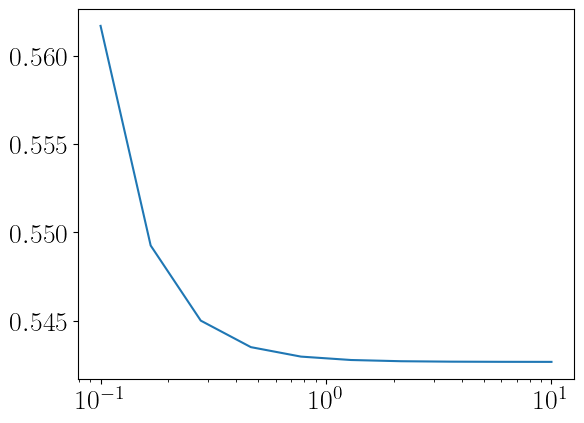

In [18]:
plt.plot(lhrange, Ghlist)
plt.xscale('log')

We can use this to further solve $L_s$ for a given $L_h$ via $G_s = 0$. $\delta s$ is assumed to be solved from $P_h - P_s = 0$ for all the points we are testing.

In [24]:
Lhrange = np.logspace(-2,1,20)
Ghrange = np.ones((20,))*100
for i in range(20):
    Lh = Lhrange[i]
    print("Computing for Lh = " + str(Lh))
    lsmin = Lh/10
    lsmax = Lh*10
    Lsrange = np.logspace(Log10(lsmin), Log10(lsmax), 20)
    Gslist = np.array([moments(Lh, Ls, solve_deltas(Lh, Ls))[-1] for Ls in Lsrange])
    # Then solve for Ls
    # If Gs = 0 reached, compute Gh for this Lh and Ls.
    # If not, discard this, return 100.
    if Gslist.min() * Gslist.max() < 0:
        Gsfunc = interpolate.interp1d(Lsrange, Gslist)
        Lssol = optimize.brentq(Gsfunc, Lsrange[0], Lsrange[-1])
        Ghrange[i] = moments(Lh, Lssol, solve_deltas(Lh, Lssol))[2]
        print("Find Ls = " + str(Lssol))
        print("Gh = " + str(Ghrange[i]))
    else:
        print("No proper Ls found.")
        continue


Computing for Lh = 0.01
Find Ls = 0.00818128182992052
Gh = 0.42601242533251227
Computing for Lh = 0.01438449888287663
Find Ls = 0.011785221780108105
Gh = 0.5410130504169937
Computing for Lh = 0.0206913808111479
Find Ls = 0.017002448660285437
Gh = 0.7201801021697521
Computing for Lh = 0.029763514416313176
Find Ls = 0.024567215925786298
Gh = 0.9540589722182657
Computing for Lh = 0.04281332398719394
Find Ls = 0.03563968720123905
Gh = 1.2002671869380965
Computing for Lh = 0.06158482110660264
Find Ls = 0.05209378820277734
Gh = 1.08435574626258
Computing for Lh = 0.08858667904100823
Find Ls = 0.0758023490662753
Gh = 0.8063008099798566
Computing for Lh = 0.12742749857031335
Find Ls = 0.10950777772237623
Gh = 0.7342955315155552
Computing for Lh = 0.18329807108324356
Find Ls = 0.1578258725292821
Gh = 0.7044807626013889
Computing for Lh = 0.26366508987303583
Find Ls = 0.2272304863662804
Gh = 0.6909569638169435
Computing for Lh = 0.37926901907322497
Find Ls = 0.32700105013812275
Gh = 0.6846057442

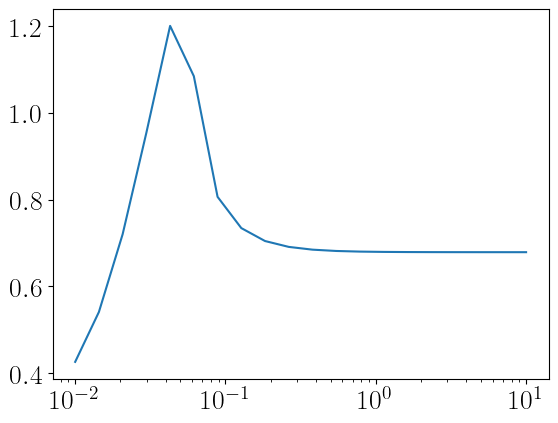

In [26]:
plt.plot(Lhrange, Ghrange)
plt.xscale('log')

In [27]:
solve_Ls(0.01)

0.00811519040076434

In [28]:
Gh_min(0.01)

0.4620006012776589

In [30]:
Gh_min(0.0001)

0.3575215895771771

In [11]:
def solve_Ls(Lh):
    """Solve Ls from Gs = 0 for a certain Lh.
    δs is always fixed to solve Ph-Ps = 0."""
    lsmin = Lh/10
    lsmax = Lh*10
    try:
        Lssol = optimize.newton(lambda Ls: moments(Lh, Ls, solve_deltas(Lh, Ls))[-1], Lh)
    except:
        Lssol = optimize.brentq(lambda Ls: moments(Lh, Ls, solve_deltas(Lh, Ls))[-1], lsmin, lsmax)
    return Lssol
    

In [12]:
Lssol = solve_Ls(1.0)
print(Lssol)

0.8591396550657807


Then the remaining is $L_h$. The condition is to vanish $G_h$.

In [13]:
def Gh_min(Lh):
    """Gh as a function of Lh, with Ls and deltas solved."""
    Lssol = solve_Ls(Lh)
    dssol = solve_deltas(Lh, Lssol)
    return moments(Lh, Lssol, dssol)[2]

In [31]:
def Ptot(Lh):
    Lssol = solve_Ls(Lh)
    dssol = solve_deltas(Lh, Lssol)
    Ph, Ps, Gh, Gs = moments(Lh, Lssol, dssol)
    return Ph + Ps

In [32]:
Ptot(0.001)

-6.380020883939934

In [33]:
Ptot(0.0001)

-6.382126274066213

In [34]:
Ptot(10)

-1.0980825090025057

In [59]:
Gh_min(1.0)

0.6980236778542181

In [14]:
lhrange = np.linspace(0.5,1.5,20)
Ghrange = np.zeros((20,))

In [15]:
for i in range(20):
    Ghrange[i] = Gh_min(lhrange[i])

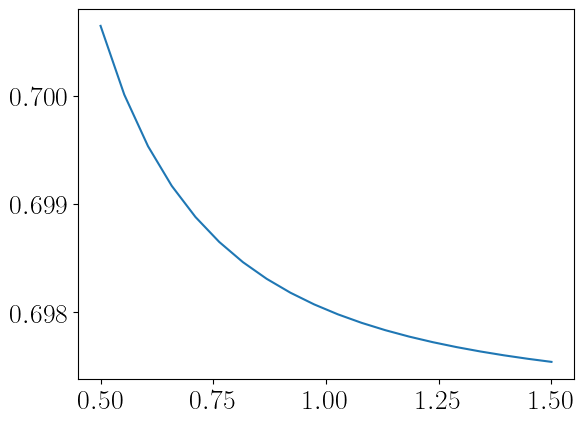

In [16]:
plt.plot(lhrange, Ghrange)

In [17]:
Gh_min(3)

0.6972506630832954

Now we are having a problem. It seems that the solution for moments does not exist. Once 2 of the solutions are satisfied there is no solution for the 3rd. Fine. Maybe we should search for a global minimization for it.

### Solve $L_h$ and $L_s$ at first then $\delta s$

In [35]:
def solve_Ls(Lh, deltas):
    try:
        dsol = optimize.newton(lambda Ls: moments(Lh, Ls, deltas)[-1],Lh)
    except:
        dsol = optimize.brentq(lambda Ls: force_diff(Lh, Ls, deltas), 0.1*Lh, 10*Lh)
    return dsol

In [36]:
solve_Ls(0.01, 0.3)

0.008768146521475772

In [38]:
Lhrange = np.logspace(-3,1,20)
Ghrange = np.zeros((20,))
for i in range(20):
    Lh = Lhrange[i]
    Ls = solve_Ls(Lh, 0.3)
    Ghrange[i] = moments(Lh, Ls, 0.3)[2]


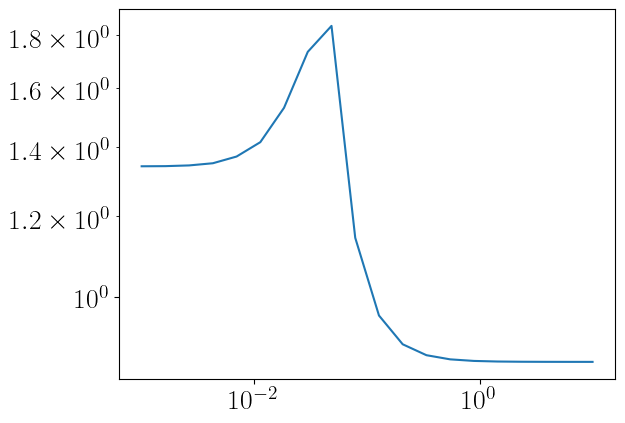

In [40]:
plt.plot(Lhrange, Ghrange)
plt.xscale('log')
plt.yscale('log')

In [ ]:
def solve_Lh(deltas):
    def Gh(Lh, deltas):
        Ls = solve_Ls(Lh, deltas)

### Global minimum method

In [18]:
def moments_min(Lh, Ls, deltas):
    Ph, Ps, Gh, Gs = moments(Lh, Ls, deltas)
    return np.sum(np.array([Ph-Ps, Gh, Gs])**2)

In [19]:
lhrange = np.logspace(-4,1,20)
lratiorange = np.logspace(0.5,2,20)
deltasrange = np.linspace(0,0.5,20)
min_range = np.ones((20,20,20))

In [20]:
for i in range(20):
    for j in range(20):
        for k in range(20):
            Lh = lhrange[i]
            Ls = Lh * lratiorange[j]
            deltas = deltasrange[k]
            min_range[i,j,k] = moments_min(Lh, Ls, deltas)

In [22]:
np.unravel_index(min_range.argmin(), min_range.shape)

(0, 1, 15)

In [23]:
min_range.min()

8.556148891662561